# Séries temporais com Regressão Linear

**Autor**: [Rafael Barbosa]()

**Participação especial**: [Maykon Schots]()

*adicionar o linkedin novamente*

**Objetivo:** Temos uma série temporal de frequência diária de vendas que inicia em Jan/2020 e termina no final de Jul/2020. Queremos prever estas vendas para a próxima semana, dada as características que estão presentes no banco de dados abaixo.

## 1. Bibliotecas e configurações adicionais


In [1]:
#--- Bibliotecas iniciais

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays


#--- Configurações adicionais

plt.style.use("seaborn-muted")
pd.set_option("display.max_columns", None)

## 2. Carregando os dados

In [2]:
dados = pd.read_csv("data/output-dados-case.csv")

dados.head()

,Lead Created At,Lead Id,Purchase Source,JID,tempo_jornada,flag_jornada,flag_venda,Canal
0,2020-01-06 22:39,MSS-00003108-bf9d-4679-8780-36931ab4ae49-2020,fb-geral-lookalike-dco,1,1.0,Primeiro Contato,0.0,FB
1,2020-02-21 19:18,MSS-00003108-bf9d-4679-8780-36931ab4ae49-2020,sms-pre-carnaval-abandono,2,47.0,Ultimo Contato,0.0,SMS
2,2020-05-13 14:15,MSS-000031d0-5499-4e58-a88d-9afbcbb8ee9a-2019,yt-rmkt-videos-videovendas3,3,143.0,Ultimo Contato,0.0,YT
3,2020-07-23 22:28,MSS-00003bb2-b409-47b3-862f-e6c82b311d0c-2020,insta-bio,1,1.0,Primeiro Contato,0.0,FB
4,2020-05-12 22:51,MSS-0000610b-1170-47f5-990b-239d6eaef81b-2020,fb-rmkt-video-dco,1,1.0,Primeiro Contato,0.0,FB


In [3]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309959 entries, 0 to 309958
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Lead Created At  309959 non-null  object 
 1   Lead Id          309959 non-null  object 
 2   Purchase Source  309959 non-null  object 
 3   JID              309959 non-null  int64  
 4   tempo_jornada    309959 non-null  float64
 5   flag_jornada     309959 non-null  object 
 6   flag_venda       293612 non-null  float64
 7   Canal            309959 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 18.9+ MB


- Observando o banco de dados, temos a informação de todas as interações em que o cliente teve com a loja

- A variável de data `Lead Created At` não está definida corretamente como data, somente como objeto

- A variável `flag_venda` indica se esta determinada interação cliente-loja resultou em uma compra ou não

- Então, o caminho para criar a nossa série temporal de vendas é:

    1. Criar uma nova variável que sempre vai ter o valor de 1, indicando a interação quantitativamente

    2. Filtrar somente as observações em que houveram venda

    3. Com isso, faremos uma agregação da soma de todas as vendas por dia

In [4]:
def modific_inicial_banco(df, var_data, var_flag_venda):
    
    """
    Função para ajustar em um formato inicial de séries temporais os dados recebidos   
    ------------
    Parâmetros:
    ------------
    
    df: DataFrame pandas;
    var_data: Variável de data a ser tratada
    var_flag_venda: Variável de indicador de venda ou não
    
    ------
    Saída:
    ------
    df: DataFrame pandas com o dia e a quantidade de vendas 
    """
    
    df1 = df.copy()
    
    df1[var_data] = pd.to_datetime(df1[var_data], format = "%Y-%m-%d")
    
    df1["indicador_leads"] = 1
    
    df1 = df1[df1[var_flag_venda] == 1].resample("D", on = var_data)["indicador_leads"].sum()
    
    return(df1.reset_index())

In [5]:
dados1 = modific_inicial_banco(df = dados, 
                               var_data = "Lead Created At", 
                               var_flag_venda = "flag_venda")

dados1.head()

,Lead Created At,indicador_leads
0,2020-01-01,47
1,2020-01-02,70
2,2020-01-03,48
3,2020-01-04,81
4,2020-01-05,73


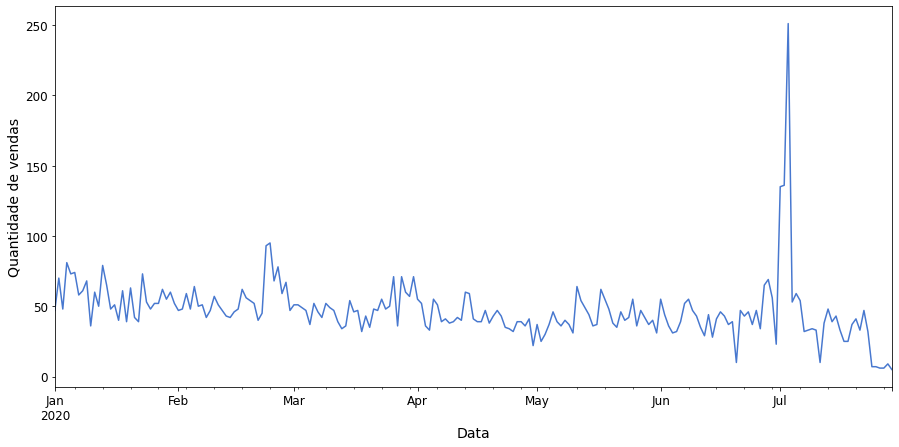

In [6]:
_ = dados1.plot(x = "Lead Created At", y = "indicador_leads", kind = "line", 
               figsize = [15, 7], legend = False)
_ = plt.xlabel("Data", fontsize = 14, color = "black")
_ = plt.ylabel("Quantidade de vendas", fontsize = 14, color = "black")
_ = plt.tick_params(axis = "x", labelsize = 12, labelcolor = "black")
_ = plt.tick_params(axis = "y", labelsize = 12, labelcolor = "black")

## 3. Definindo a métrica

- Raiz Quadrada do Erro Quadrático Médio

$$ \text{RMSE} = \sqrt{\frac{1}{n}\sum_{i}(y_i - \hat{y}_i)} $$

## 4. Variáveis para a modelagem